In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/arpit/OneDrive/Desktop/cloud-cost-leakage/data/processed/cloud_billing_synthetic.csv", parse_dates=["date"])
df.head()


,date,service_name,cost,resource_id,region,usage_amount
0,2023-01-05,Automation,0.081771,automation-8270,asia-south-1,22.776161
1,2023-01-05,Azure DNS,40.914076,azure-dns-1860,eu-west-1,26.420740
2,2023-01-05,Bandwidth,10447.971390,bandwidth-6390,asia-south-1,357.449100
3,2023-01-05,Storage,10998.601240,storage-6191,us-east-1,322.722202
4,2023-01-05,Virtual Machines,4543.884576,virtual-machines-6734,eu-west-1,97.460387


In [2]:
resource_df = (
    df.groupby("resource_id")
    .agg(
        total_cost=("cost", "sum"),
        total_usage=("usage_amount", "sum"),
        active_days=("date", "nunique"),
        service_name=("service_name", "first"),
        region=("region", "first")
    )
    .reset_index()
)

resource_df.head()


,resource_id,total_cost,total_usage,active_days,service_name,region
0,automation-8270,0.081771,22.776161,1,Automation,asia-south-1
1,azure-dns-1161,165.684666,3.202197,1,Azure DNS,us-east-1
2,azure-dns-1860,40.914076,26.420740,1,Azure DNS,eu-west-1
3,azure-dns-2899,40.049060,41.929822,1,Azure DNS,us-east-1
4,azure-dns-5426,39.982764,25.365177,1,Azure DNS,us-east-1


In [3]:
resource_df["cost_per_day"] = resource_df["total_cost"] / resource_df["active_days"]
resource_df["usage_per_day"] = resource_df["total_usage"] / resource_df["active_days"]

resource_df.describe()


,total_cost,total_usage,active_days,cost_per_day,usage_per_day
count,89.000000,89.000000,89.0,89.000000,89.000000
mean,4105.689746,126.817986,1.0,4105.689746,126.817986
std,4919.031493,170.852688,0.0,4919.031493,170.852688
min,0.000000,1.248018,1.0,0.000000,1.248018
25%,40.309546,30.184238,1.0,40.309546,30.184238
50%,1962.025702,68.065551,1.0,1962.025702,68.065551
75%,10277.241380,97.581783,1.0,10277.241380,97.581783
max,19144.324258,789.237841,1.0,19144.324258,789.237841


In [4]:
cost_threshold = resource_df["cost_per_day"].quantile(0.75)
usage_threshold = resource_df["usage_per_day"].quantile(0.25)


In [5]:
idle_resources = resource_df[
    (resource_df["cost_per_day"] >= cost_threshold) &
    (resource_df["usage_per_day"] <= usage_threshold)
]

idle_resources.sort_values("cost_per_day", ascending=False).head(10)


,resource_id,total_cost,total_usage,active_days,service_name,region,cost_per_day,usage_per_day
15,backup-9684,19144.324258,24.472725,1,Backup,us-east-1,19144.324258,24.472725


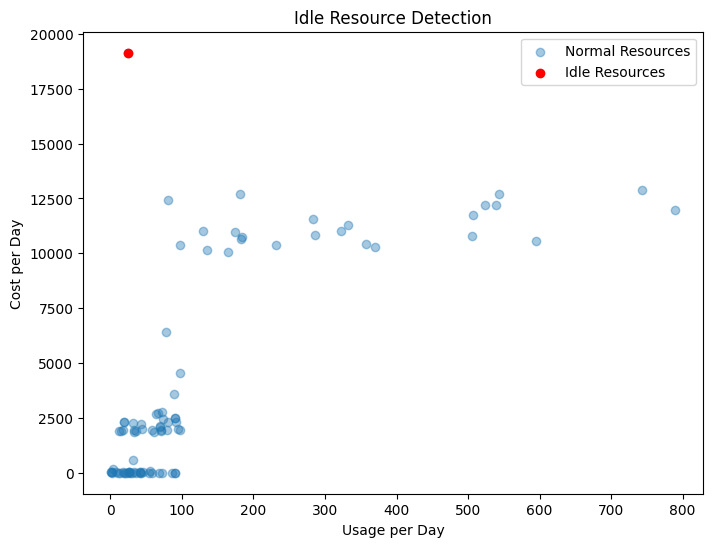

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(
    resource_df["usage_per_day"],
    resource_df["cost_per_day"],
    alpha=0.4,
    label="Normal Resources"
)

plt.scatter(
    idle_resources["usage_per_day"],
    idle_resources["cost_per_day"],
    color="red",
    label="Idle Resources"
)

plt.xlabel("Usage per Day")
plt.ylabel("Cost per Day")
plt.legend()
plt.title("Idle Resource Detection")
plt.show()


In [ ]:
def explain_idle_resources(idle_df):
    explanations = []
    for _, row in idle_df.head(5).iterrows():
        explanations.append(
            f"Resource {row['resource_id']} ({row['service_name']}, {row['region']}) "
            f"costs {row['cost_per_day']:.2f} per day but has very low usage "
            f"({row['usage_per_day']:.2f}), indicating potential cost leakage."
        )
    return explanations

explain_idle_resources(idle_resources)
